# Лекция 4. Понижение размерности признаков

Загрузим необходимые библиотеки:

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from pandas.plotting import scatter_matrix
from scipy import stats
import math
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
os.chdir("C:/Users/HP/Documents/analysis/Marketing/data/")

## Метод главных компонент (principal component analysis, PCA)

Теория:
* https://medium.com/@ns2586/detecting-the-fault-line-using-principal-component-analysis-pca-7d5d265336a3

Метод главных компонент — быстрый и гибкий метод машинного обучения без учителя, предназначенный для понижения размерности данных.

PCA представляет собой алгоритм понижения размерности, но он может быть также удобен в качестве инструмента визуализации, фильтрации шума, выделения и проектирования признаков, а также многого другого.

Рассмотрим двумерный набор данных из 200 точек.

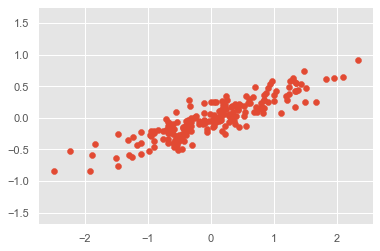

In [3]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

Визуально очевидно, что зависимость между величинами x и y практически линейная.

Задача машинного обучения без учителя состоит в выяснении зависимости между величинами x и y, а не в предсказании значений величины y по значениям величины x.

В методе главных компонент выполняется количественная оценка этой зависимости путем нахождения списка главных осей координат (principal axes) данных и их использования для описания набора данных. Выполнить это с помощью оценивателя PCA из библиотеки Scikit-Learn можно следующим образом:

In [4]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

При обучении алгоритм определяет некоторые относящиеся к данным величины, самые важные из них — компоненты и объяснимая дисперсия (explained variance):

In [5]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [6]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


Чтобы понять смысл этих чисел, визуализируем их в виде векторов над входными данными, используя компоненты для задания направления векторов, а объяснимую дисперсию — в качестве квадратов их длин:

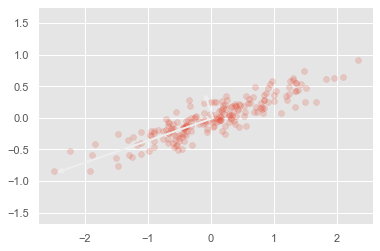

In [7]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

Эти векторы отражают главные оси координат данных, а показанная на рисунке выше длина соответствует «важности» роли данной оси при описании распределения данных, точнее говоря, это мера дисперсии данных при проекции на эту ось. Проекции точек данных на главные оси и есть главные компоненты данных.

Переход от осей координат данных к главным осям представляет собой аффинное преобразование (affine transformation). По существу, это значит, что оно состоит из сдвига (translation), вращения (rotation) и пропорционального масштабирования (uniform scaling).

### PCA как метод понижения размерности

Использование метода PCA для понижения размерности включает обнуление одной или нескольких из наименьших главных компонент, в результате чего данные проецируются на пространство меньшей размерности с сохранением максимальной дисперсии данных.

Вот пример использования PCA в качестве понижающего размерность преобразования:

In [8]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


Преобразованные данные стали одномерными. Для лучшего понимания эффекта этого понижения размерности можно выполнить обратное преобразование этих данных и нарисовать их рядом с исходными.

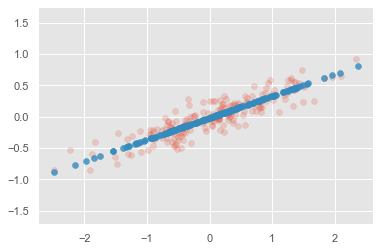

In [9]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

Более светлые точки — исходные данные, а более темные — спроецированная версия. Из рисунка становится понятно, что означает понижение размерности с помощью PCA: информация по наименее важной главной оси/осям координат уничтожается и остается только компонента (-ы) данных с максимальной дисперсией. Отсекаемая часть дисперсии (пропорциональная разбросу точек рядом с линией, показанному на рисунке) является приближенной мерой того, сколько «информации» отбрасывается при этом понижении размерности.

Факторный анализ
==================

## Пример факторного анализа поведения самцов корюшки

Будем анализировать поведение самцов корюшки.

LUNGES Количество нападений (удары) на модель самца.<br>
BITES Количество нападений (укусы) на модель самца.<br>
ZIGZAGS	Плавание зигзагом, которое является частью поведения, направленного на привлечение самок.<br>
NEST Действия, связанные с построением гнезда.<br>
SPINES Число раз, когда топорщился колючий верхний плавник.<br>
DNEST Суммарная длительность времени, проведенного за построением гнезда.<br>
BOUT Количество элементов поведения, характеризующих готовность к схватке.<br>

In [10]:
df = pd.read_csv('stickleback.csv', sep=';', decimal=',')
df.head()

,LUNGES,BITES,ZIGZAGS,NEST,SPINES,DNEST,BOUT,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,79.0,25.0,0.0,0.0,15.0,0.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,136.0,58.0,6.0,0.0,15.0,0.0,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,115.0,30.0,2.0,1.0,9.0,5.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,129.0,139.0,16.0,0.0,22.0,0.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,120.0,58.0,15.0,15.0,14.0,82.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df = df.filter(regex='^(?!.*Unnamed).*$')
df.head()

,LUNGES,BITES,ZIGZAGS,NEST,SPINES,DNEST,BOUT
0,79.0,25.0,0.0,0.0,15.0,0.0,45.0
1,136.0,58.0,6.0,0.0,15.0,0.0,148.0
2,115.0,30.0,2.0,1.0,9.0,5.0,29.0
3,129.0,139.0,16.0,0.0,22.0,0.0,69.0
4,120.0,58.0,15.0,15.0,14.0,82.0,9.0


In [12]:
df.describe()

,LUNGES,BITES,ZIGZAGS,NEST,SPINES,DNEST,BOUT
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,131.185185,69.055556,7.277778,1.425926,18.425926,34.259259,89.314815
std,50.771064,43.428283,6.693891,3.000641,8.712606,56.491170,98.679742
min,41.000000,3.000000,0.000000,0.000000,5.000000,0.000000,6.000000
25%,99.000000,34.250000,2.250000,0.000000,14.000000,0.000000,23.500000
50%,127.000000,60.000000,5.000000,0.000000,16.000000,0.000000,45.000000
75%,156.750000,84.250000,10.750000,1.000000,24.750000,73.000000,125.000000
max,277.000000,175.000000,26.000000,15.000000,46.000000,199.000000,306.000000


In [13]:
df.corr()

,LUNGES,BITES,ZIGZAGS,NEST,SPINES,DNEST,BOUT
LUNGES,1.000000,0.688077,-0.139336,-0.164133,0.055567,-0.228568,0.233314
BITES,0.688077,1.000000,-0.042761,-0.148884,0.373382,-0.217563,0.117316
ZIGZAGS,-0.139336,-0.042761,1.000000,0.351894,0.067813,0.091315,-0.160693
NEST,-0.164133,-0.148884,0.351894,1.000000,-0.052538,0.514028,-0.305876
SPINES,0.055567,0.373382,0.067813,-0.052538,1.000000,-0.051099,-0.041483
DNEST,-0.228568,-0.217563,0.091315,0.514028,-0.051099,1.000000,-0.242177
BOUT,0.233314,0.117316,-0.160693,-0.305876,-0.041483,-0.242177,1.000000


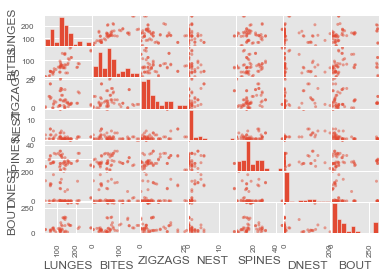

In [14]:
scatter_matrix(df);

Видим, что данные признаки (фичи) далеки от нормальных, корреляции между признаками (фичами) не наблюдается. 

Выделим первоначальные факторы методом главных компонент.

## Метод главных компонент

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Cтандартизируем переменные. Из предварительного анализа видно, что это важно.

In [15]:
# Функция для стандартизации фич
def scale_features(df):
    scaled = preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    return scaled

In [16]:
df_scaled = preprocessing.scale(df)

Попробуем с помощью метода главных компонент спроецировать 
данные на двумерную плоскость. 
То есть выделим две главных компоненты. 
Реализация метода содержится в классе ```PCA``` 
библиотеки ```sklearn.decomposition```.



In [17]:
pca = PCA(n_components=3)
pca.fit(df_scaled)
print(pca.explained_variance_ratio_)

[0.32687739 0.20774873 0.13987346]


Координаты самих компонент находятся в атрибуте ```components_```.

In [18]:
print (pca.components_)

[[-0.47012791 -0.45897962  0.24811772  0.43535559 -0.16394905  0.42179779
  -0.33530269]
 [ 0.31046609  0.50737164  0.37893225  0.40026456  0.46520814  0.22423164
  -0.2751091 ]
 [ 0.48163265  0.12992711 -0.24381636  0.32733909 -0.62180282  0.39879993
   0.1971586 ]]


In [19]:
print ('Explained variance by component: %s' % pca.explained_variance_ratio_)

Explained variance by component: [0.32687739 0.20774873 0.13987346]


In [20]:
pca.singular_values_

array([11.11573903,  8.86166018,  7.27132493])

In [21]:
pca.explained_variance_ratio_

array([0.32687739, 0.20774873, 0.13987346])

In [22]:
zzz = pca.transform(df_scaled)

In [1]:
#zzz

## Факторный анализ


http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
 

Попробуем с помощью факторного анализа построить новые фичи, которые были бы более удобными в использовании с минимальной потерей информации.

Используем класс ```FactorAnalysis``` из ```sklearn.decomposition```. 
Начнём с двух факторов.

In [23]:
fa = FactorAnalysis(n_components=2)
fa.fit(df_scaled)

FactorAnalysis(n_components=2)

Координаты факторов в пространстве старых фич находятся в атрибуте ```components_```.

In [24]:
pd.DataFrame(fa.components_, columns=df.columns)

,LUNGES,BITES,ZIGZAGS,NEST,SPINES,DNEST,BOUT
0,0.715035,0.956805,-0.086423,-0.241141,0.358615,-0.282219,0.166892
1,-0.019296,0.098533,0.367721,0.848657,0.073328,0.513705,-0.329849


Видим, что первый (нулевой) фактор сильно коррелирует с фичами-нападениями (ударами и укусами), так что его можно интерпретировать как агрессивность самца. Второй же фактор, напротив, коррелирует с фичами, связанными с обустройство гнезда, что можно расценивать как "домовитость". То есть мы свели пространство из семи фич к двум новым интерпретируемым фичам.

Уникальность фич в смысле дисперсии, объяснённой факторами (чем больше, тем хуже объясняется факторами) содержится в атрибуте ```noise_variance_```.

In [25]:
print('Uniqueness:')
pd.Series(fa.noise_variance_, df.columns)

Uniqueness:


LUNGES     0.487766
BITES      0.076163
ZIGZAGS    0.857251
NEST       0.222906
SPINES     0.866169
DNEST      0.656093
BOUT       0.863093
dtype: float64

Наконец, сами факторы (как новые векторы-фичи) можно получить, применив метод ```transform```.

In [26]:
scores = pd.DataFrame(fa.transform(df_scaled), columns=['factor1', 'factor2'])
scores.head()

,factor1,factor2
0,-0.938788,-0.776068
1,-0.159453,-0.591389
2,-0.818776,-0.458188
3,1.444012,0.094633
4,-0.638620,3.662073


In [2]:
#scores

Попробуем теперь построить не два, а три фактора. Что изменится?

In [27]:
fa = FactorAnalysis(n_components=3)
fa.fit(df_scaled)
pd.DataFrame(fa.components_, columns=df.columns)

,LUNGES,BITES,ZIGZAGS,NEST,SPINES,DNEST,BOUT
0,0.832106,0.851016,-0.180171,-0.390928,0.261270,-0.375792,0.267079
1,0.178973,0.241522,0.331612,0.808428,0.099520,0.441922,-0.266378
2,-0.301530,0.213190,0.145993,-0.051025,0.592552,-0.020361,-0.175361


Первые два фактора сохранили свой смысл -- агрессивность и домовитость (только корреляции чуть уменьшились), а вот третий фактор интерпретировать уже сложно. Он коррелирует только с одной фичей SPINES, а значит не несёт какой-то новой информации. Так что всё же лучше оставить только два фактора.